In [75]:
!pip install dictances

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for dictances: filename=dictances-1.5.3-py3-none-any.whl size=13676 sha256=e59f978f44b9407c64b69bb50b6e781f8a8f468de13ac27f673b16a9c547b5db
  Stored in directory: c:\users\andre\appdata\local\pip\cache\wheels\3e\78\5b\14f3a658aca463e8816c14d011a7971da9bf1e9d6e069e83f4
Successfully built dictances


In [361]:
import pickle

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy import spatial
from collections import Counter
from scipy.special import rel_entr
from torchvision.datasets import Caltech101
from sklearn.model_selection import train_test_split

In [362]:
caltech101 = Caltech101('./caltech101', download=True)
caltech101

Files already downloaded and verified


Dataset Caltech101
    Number of datapoints: 8677
    Root location: ./caltech101\caltech101
    Target type: ['category']

In [363]:
def filter_by_category(category: int, max_length: int = 20):
    return [x for x in caltech101 if x[1] == category][:max_length]


def filter_by_categories(categories: list[int], max_length: int = 20):
    return np.concatenate([filter_by_category(c, max_length) for c in categories], dtype='object')

In [ ]:
categories = range(1, 21)
dataset = filter_by_categories(categories, max_length=50)

In [13]:
dataset

array([[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=290x334 at 0x1930708B5B0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=263x332 at 0x19307088760>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=279x308 at 0x193508C1AE0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=261x322 at 0x193508C21A0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=290x330 at 0x193508C1C60>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=289x329 at 0x193508C26E0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=276x342 at 0x193508C2590>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=287x335 at 0x193508C0FA0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=263x324 at 0x193508C3B80>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=264x331 at 0x193508

In [14]:
def dataset_to_df(dataset):
    return pd.DataFrame(dataset, columns=['image', 'category'])

In [15]:
train_dataset, test_dataset = train_test_split(dataset, train_size=.5)
train_df = dataset_to_df(train_dataset)
test_df = dataset_to_df(test_dataset)

In [68]:
def to_gray(img):
    array = np.array(img)
    gray = cv.cvtColor(array, cv.COLOR_BGR2GRAY)
    return gray


def sift(gray_img):
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc


def imshow_key_points(img):
    gray = to_gray(img_ex)
    kp, _ = sift(gray)
    plt.imshow(cv.drawKeypoints(gray, kp, img))
    plt.axis('off')
    plt.show()


def get_centroid_nn(descriptor, centroids):
    tree = spatial.KDTree(centroids)
    dist, idxs = tree.query(descriptor)
    return idxs


def get_bag_of_words(descriptor, centroids):
    idxs = get_centroid_nn(descriptor, centroids)
    bow = Counter(idxs)
    return bow, idxs


def elbow(ks, inertias):
    plt.plot(ks, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Values of k')
    plt.ylabel('Distortion')
    plt.show()


def get_sift_descriptors(dataset):
    descriptors = {}
    key_points = {}
    for img, cls in tqdm(dataset):
        array = np.array(img)
        if len(array.shape) == 3:
            gray = to_gray(img)
        else:
            gray = array
        kp, desc = sift(gray)
        key_points[img.filename] = kp
        descriptors[img.filename] = desc
    return key_points, descriptors

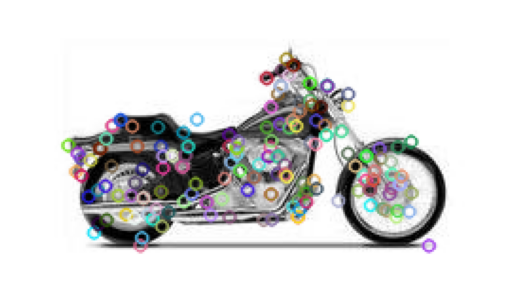

In [28]:
img_ex = train_dataset[0][0]
imshow_key_points(np.array(img_ex))

In [20]:
key_points, descriptors = get_sift_descriptors(dataset)
_, train_descriptors = get_sift_descriptors(train_dataset)
_, test_descriptors = get_sift_descriptors(test_dataset)

100%|██████████| 50/50 [00:00<00:00, 89.34it/s]


In [153]:
ks = range(200, 600, 100)


def kmeans_clustering(descriptors):
    criteria = cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0
    flags = cv.KMEANS_RANDOM_CENTERS
    distortions = {}
    cluster_centroids = {}
    desc = np.concatenate(list(descriptors.values()))

    for k in ks:
        print(k, end='\r')
        compactness, _, centers = cv.kmeans(desc, k, None, criteria, 10, flags)
        cluster_centroids[k] = centers
        dist = np.min(spatial.distance.cdist(desc, centers, 'euclidean'), axis=1)
        distortions[k] = sum(dist / len(desc))

    return cluster_centroids, distortions

In [150]:
train_centroids, train_distortions = kmeans_clustering(train_descriptors)

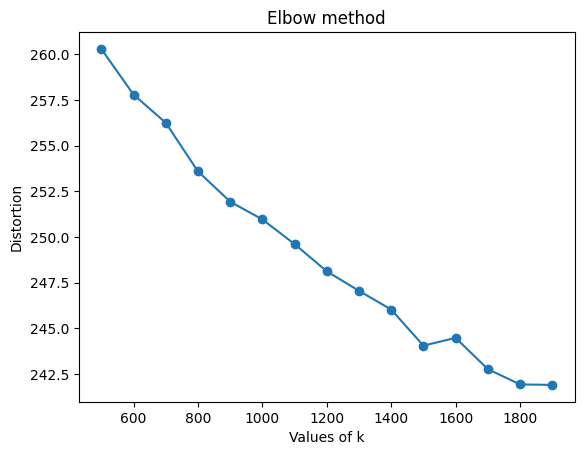

In [606]:
elbow(ks, list(train_distortions.values()))

In [339]:
def get_retrieval_table(dataset, descriptors, centroids, train=True):
    table = []
    for img, cls in tqdm(dataset):
        counts, words = get_bag_of_words(centroids, descriptors[img.filename])

        table.append(dict(filename=img.filename,
                          category=cls,
                          train_set=train,
                          words=words,
                          bag_of_words=counts))
    return table

In [340]:
centroids = train_centroids[min(train_distortions, key=lambda x: train_distortions[x])]
titles = ['filename', 'category', 'train_set', 'words', 'bag_of_words']

train_table = get_retrieval_table(train_dataset, train_descriptors, centroids, train=True)
test_table = get_retrieval_table(test_dataset, test_descriptors, centroids, train=False)

100%|██████████| 50/50 [00:02<00:00, 19.51it/s]


In [341]:
retrieval_table = pd.DataFrame(train_table + test_table, columns=titles)
train_table = pd.DataFrame(train_table, columns=titles)
test_table = pd.DataFrame(test_table, columns=titles)

### TF-Idf

In [359]:
def count_to_tf(counter):
    tf = {}
    sm = sum(counter.values())
    for word in counter:
        tf[word] = counter[word] / sm
    return tf


def get_idfs(bows):
    # get the words that
    occurrences = []
    for row in bows:
        occurrences += row.keys()

    keys = set(occurrences)
    nr_occurrences = Counter(occurrences)

    idfs = {}
    for centroid in keys:
        idfs[centroid] = np.log(len(bows) / nr_occurrences[centroid])
    return idfs


def tf_idfs(tfs):
    tf_idfs = {}
    idfs = get_idfs(retrieval_table['bag_of_words'])
    for key in tfs:
        tf_idfs[key] = tfs[key] * idfs[key]
    return tf_idfs


def add_tf_idf(df):
    df['tf'] = df['bag_of_words'].apply(count_to_tf)
    df['tf_idf'] = df['tf'].apply(tf_idfs)
    df.drop(columns=['tf'])

In [360]:
add_tf_idf(retrieval_table)
add_tf_idf(train_table)
add_tf_idf(test_table)

In [347]:
retrieval_table

,filename,category,train_set,words,bag_of_words,tf,tf_idf
0,./caltech101\caltech101\101_ObjectCategories\M...,3,True,"[59, 40, 59, 68, 68, 78, 96, 85, 115, 92, 56, ...","{59: 21, 40: 2, 68: 17, 78: 2, 96: 2, 85: 2, 1...","{59: 0.042, 40: 0.004, 68: 0.034, 78: 0.004, 9...","{59: 0.01874405831039362, 40: 0.00184814183838..."
1,./caltech101\caltech101\101_ObjectCategories\L...,2,True,"[85, 83, 98, 30, 6, 56, 57, 18, 95, 68, 21, 53...","{85: 8, 83: 23, 98: 3, 30: 11, 6: 5, 56: 2, 57...","{85: 0.016, 83: 0.046, 98: 0.006, 30: 0.022, 6...","{85: 0.006407641065554006, 83: 0.0198160141402..."
2,./caltech101\caltech101\101_ObjectCategories\L...,2,True,"[80, 23, 80, 19, 72, 80, 55, 31, 62, 24, 51, 4...","{80: 8, 23: 3, 19: 5, 72: 6, 55: 2, 31: 3, 62:...","{80: 0.016, 23: 0.006, 19: 0.01, 72: 0.012, 55...","{80: 0.005937018902253312, 23: 0.0029657779308..."
3,./caltech101\caltech101\101_ObjectCategories\a...,5,True,"[253, 330, 148, 253, 329, 88, 29, 18, 30, 304,...","{253: 4, 330: 3, 148: 2, 329: 5, 88: 1, 29: 3,...","{253: 0.008, 330: 0.006, 148: 0.004, 329: 0.01...","{253: 0.009902994848012938, 330: 0.00965662747..."
4,./caltech101\caltech101\101_ObjectCategories\L...,2,True,"[231, 96, 84, 64, 244, 33, 234, 204, 177, 17, ...","{231: 6, 96: 6, 84: 4, 64: 2, 244: 7, 33: 4, 2...","{231: 0.012, 96: 0.012, 84: 0.008, 64: 0.004, ...","{231: 0.013303951494259334, 96: 0.004109883707..."
...,...,...,...,...,...,...,...
95,./caltech101\caltech101\101_ObjectCategories\a...,4,False,"[384, 459, 261, 302, 70, 372, 448, 104, 266, 2...","{384: 2, 459: 4, 261: 4, 302: 3, 70: 4, 372: 3...","{384: 0.004, 459: 0.008, 261: 0.008, 302: 0.00...","{384: 0.007087827367727502, 459: 0.01517695987..."
96,./caltech101\caltech101\101_ObjectCategories\L...,2,False,"[13, 101, 16, 9, 13, 67, 73, 154, 35, 85, 11, ...","{13: 12, 101: 4, 16: 3, 9: 6, 67: 1, 73: 7, 15...","{13: 0.024, 101: 0.008, 16: 0.006, 9: 0.012, 6...","{13: 0.00997237065507998, 101: 0.0034462633287..."
97,./caltech101\caltech101\101_ObjectCategories\F...,1,False,"[300, 18, 320, 207, 228, 130, 267, 79, 88, 241...","{300: 2, 18: 1, 320: 2, 207: 8, 228: 3, 130: 4...","{300: 0.004, 18: 0.002, 320: 0.004, 207: 0.016...","{300: 0.006859193712367707, 18: 0.000924070919..."
98,./caltech101\caltech101\101_ObjectCategories\L...,2,False,"[197, 188, 17, 238, 197, 239, 243, 193, 216, 1...","{197: 2, 188: 1, 17: 7, 238: 2, 239: 5, 243: 3...","{197: 0.004, 188: 0.002, 17: 0.014, 238: 0.004...","{197: 0.0031061151579959852, 188: 0.0014266997..."


In [348]:
pickle.dump(retrieval_table, open('./src/retrieval_table.sav', 'wb'))
pickle.dump(train_table, open('./src/train_table.sav', 'wb'))
pickle.dump(test_table, open('./src/test_table.sav', 'wb'))

### Retrieval

In [349]:
retrieval_table = pickle.load(open('./src/retrieval_table.sav', 'rb'))
train_table = pickle.load(open('./src/train_table.sav', 'rb'))
test_table = pickle.load(open('./src/test_table.sav', 'rb'))

retrieval_table

,filename,category,train_set,words,bag_of_words,tf,tf_idf
0,./caltech101\caltech101\101_ObjectCategories\M...,3,True,"[59, 40, 59, 68, 68, 78, 96, 85, 115, 92, 56, ...","{59: 21, 40: 2, 68: 17, 78: 2, 96: 2, 85: 2, 1...","{59: 0.042, 40: 0.004, 68: 0.034, 78: 0.004, 9...","{59: 0.01874405831039362, 40: 0.00184814183838..."
1,./caltech101\caltech101\101_ObjectCategories\L...,2,True,"[85, 83, 98, 30, 6, 56, 57, 18, 95, 68, 21, 53...","{85: 8, 83: 23, 98: 3, 30: 11, 6: 5, 56: 2, 57...","{85: 0.016, 83: 0.046, 98: 0.006, 30: 0.022, 6...","{85: 0.006407641065554006, 83: 0.0198160141402..."
2,./caltech101\caltech101\101_ObjectCategories\L...,2,True,"[80, 23, 80, 19, 72, 80, 55, 31, 62, 24, 51, 4...","{80: 8, 23: 3, 19: 5, 72: 6, 55: 2, 31: 3, 62:...","{80: 0.016, 23: 0.006, 19: 0.01, 72: 0.012, 55...","{80: 0.005937018902253312, 23: 0.0029657779308..."
3,./caltech101\caltech101\101_ObjectCategories\a...,5,True,"[253, 330, 148, 253, 329, 88, 29, 18, 30, 304,...","{253: 4, 330: 3, 148: 2, 329: 5, 88: 1, 29: 3,...","{253: 0.008, 330: 0.006, 148: 0.004, 329: 0.01...","{253: 0.009902994848012938, 330: 0.00965662747..."
4,./caltech101\caltech101\101_ObjectCategories\L...,2,True,"[231, 96, 84, 64, 244, 33, 234, 204, 177, 17, ...","{231: 6, 96: 6, 84: 4, 64: 2, 244: 7, 33: 4, 2...","{231: 0.012, 96: 0.012, 84: 0.008, 64: 0.004, ...","{231: 0.013303951494259334, 96: 0.004109883707..."
...,...,...,...,...,...,...,...
95,./caltech101\caltech101\101_ObjectCategories\a...,4,False,"[384, 459, 261, 302, 70, 372, 448, 104, 266, 2...","{384: 2, 459: 4, 261: 4, 302: 3, 70: 4, 372: 3...","{384: 0.004, 459: 0.008, 261: 0.008, 302: 0.00...","{384: 0.007087827367727502, 459: 0.01517695987..."
96,./caltech101\caltech101\101_ObjectCategories\L...,2,False,"[13, 101, 16, 9, 13, 67, 73, 154, 35, 85, 11, ...","{13: 12, 101: 4, 16: 3, 9: 6, 67: 1, 73: 7, 15...","{13: 0.024, 101: 0.008, 16: 0.006, 9: 0.012, 6...","{13: 0.00997237065507998, 101: 0.0034462633287..."
97,./caltech101\caltech101\101_ObjectCategories\F...,1,False,"[300, 18, 320, 207, 228, 130, 267, 79, 88, 241...","{300: 2, 18: 1, 320: 2, 207: 8, 228: 3, 130: 4...","{300: 0.004, 18: 0.002, 320: 0.004, 207: 0.016...","{300: 0.006859193712367707, 18: 0.000924070919..."
98,./caltech101\caltech101\101_ObjectCategories\L...,2,False,"[197, 188, 17, 238, 197, 239, 243, 193, 216, 1...","{197: 2, 188: 1, 17: 7, 238: 2, 239: 5, 243: 3...","{197: 0.004, 188: 0.002, 17: 0.014, 238: 0.004...","{197: 0.0031061151579959852, 188: 0.0014266997..."


In [350]:
from dictances import bhattacharyya, cosine


def common_words(bow1, bow2):
    return len(np.intersect1d(bow1, bow2))


def kl_divergence(bow1, bow2):
    return sum(rel_entr(bow1, bow2))

In [351]:
def run_experiment(metric=common_words, column='bag_of_words', train_idx=25, test_idx=25):
    metrics_train = {}
    metrics_test = {}

    experiment_train = train_table.loc[train_idx]
    experiment_test = test_table.loc[test_idx]

    for _, train_img in train_table.iterrows():
        metrics_train[train_img.filename] = metric(experiment_train[column], train_img[column])
        metrics_test[train_img.filename] = metric(experiment_test[column], train_img[column])

    experiment_train = Image.open(experiment_train.filename)
    experiment_test = Image.open(experiment_test.filename)

    retrieved_train = Image.open(max(metrics_train, key=lambda k: metrics_train[k]))
    retrieved_test = Image.open(max(metrics_test, key=lambda k: metrics_test[k]))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 9))
    ax1.imshow(experiment_train)
    ax1.axis('off')
    ax1.set_title('Train Img')
    ax2.imshow(retrieved_train)
    ax2.set_title('Retrieved Train')
    ax2.axis('off')
    ax3.imshow(experiment_test)
    ax3.set_title('Test Img')
    ax3.axis('off')
    ax4.imshow(retrieved_test)
    ax4.set_title('Retrieved Test')
    ax4.axis('off')
    plt.show()

    return metrics_train, metrics_test

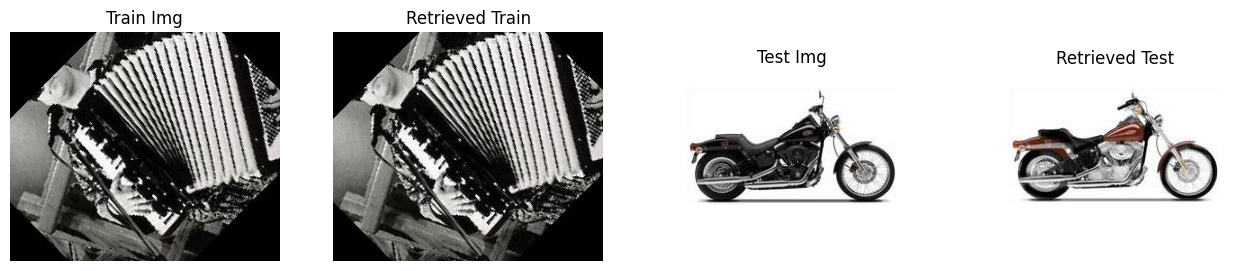

In [352]:
metrics_common_words_train, metrics_common_words_test = run_experiment(common_words, 'bag_of_words', 25, 25)

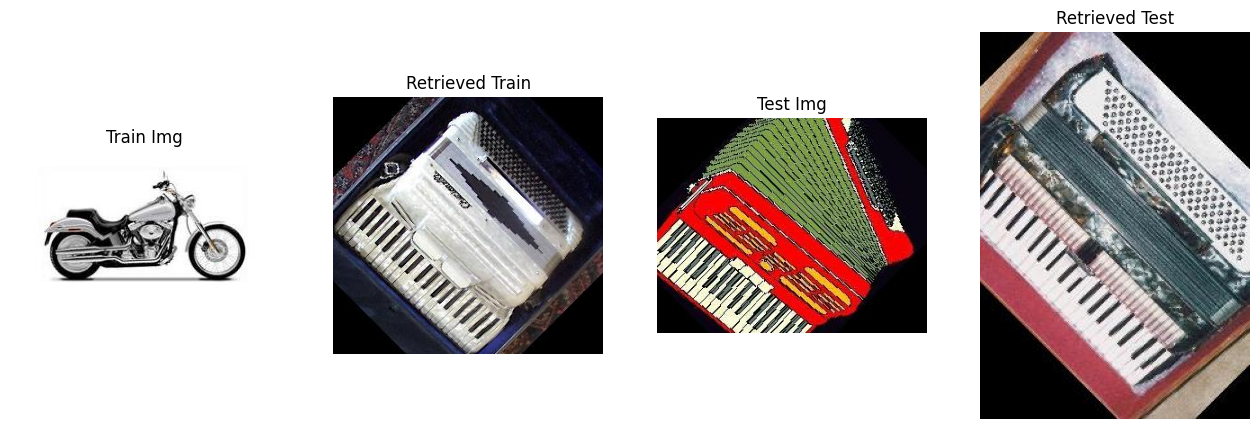

In [353]:
metrics_bht_dist_train, metrics_bht_dist_test = run_experiment(bhattacharyya, 'bag_of_words', 20, 30)

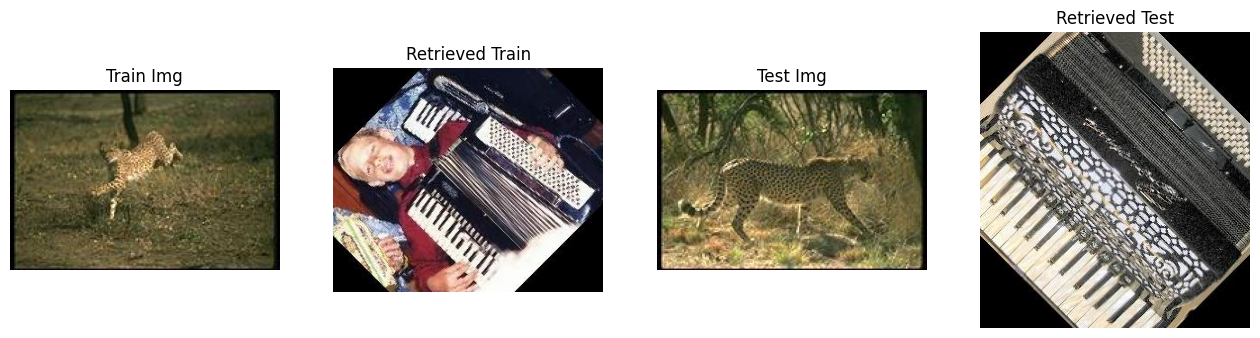

In [354]:
metrics_tfidf_train, metrics_tfidf_test = run_experiment(cosine, 'tf_idf', 10, 10)